<a href="https://colab.research.google.com/github/Nowshin1009/Natural-Image-model/blob/main/image_dataprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive



In [3]:
# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import random


In [5]:
import zipfile

zip_path = "/content/drive/MyDrive/Colab Notebooks/natural_images.zip"  # Update the correct path
extract_path = "/content/natural_images"  # Where to extract

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [6]:
dataset_path = "/content/natural_images/natural_images"
print(os.listdir(dataset_path))

['car', 'cat', 'fruit', 'person', 'motorbike', 'dog', 'airplane', 'flower']


# Loop through each **category**

In [7]:

image_size = (128, 128)  # Resize to 128x128
num_samples_per_class = 100  # Adjust based on available images

data = []
labels = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        random.shuffle(images)  # Shuffle images
        images = images[:num_samples_per_class]  # Limit samples

        for img_name in images:
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)

            if img is None:  # Skip if image is unreadable
                print(f"Failed to read: {img_path}")
                continue

            img = cv2.resize(img, image_size)  # Resize
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

            data.append(img.flatten())  # Flatten image into a 1D array
            labels.append(category)  # Store label

# Convert to NumPy array for easier processing
data = np.array(data)
labels = np.array(labels)

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


Data shape: (800, 16384)
Labels shape: (800,)


# Data Augmentation

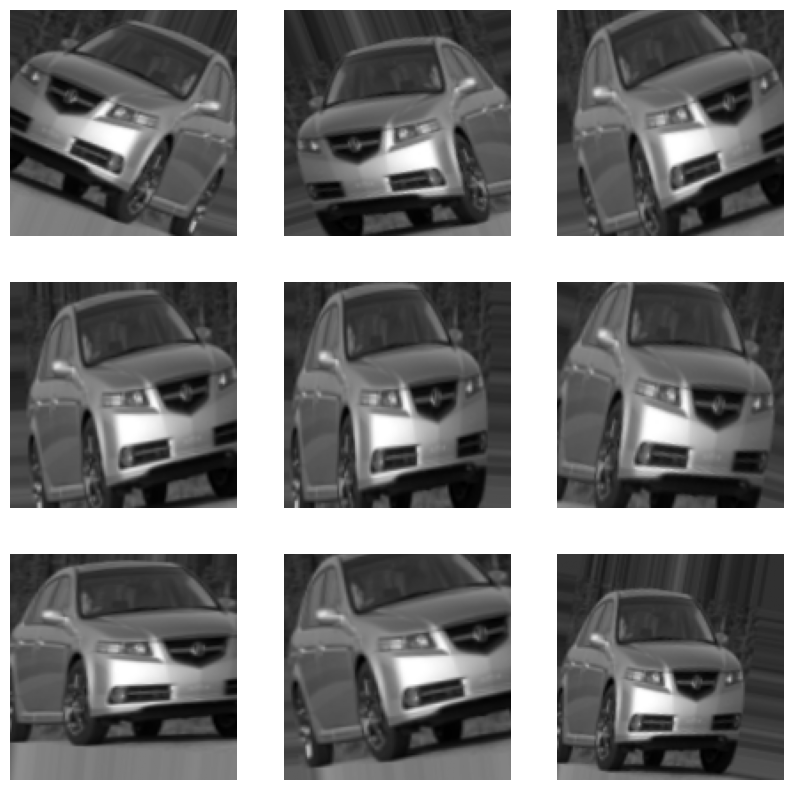

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images
    width_shift_range=0.1,  # Randomly shift images horizontally
    height_shift_range=0.1, # Randomly shift images vertically
    shear_range=0.2,        # Shear angle in counter-clockwise direction
    zoom_range=0.2,         # Randomly zoom images
    horizontal_flip=True,    # Randomly flip images
    fill_mode='nearest'     # Fill in new pixels after a transformation
)

# Example to augment a single image
sample_image = data[0].reshape(image_size[0], image_size[1])  # Reshape back to 2D
sample_label = labels[0]

# Reshape to include channels
sample_image = sample_image.reshape((1, image_size[0], image_size[1], 1))  # Add channel dimension
augmented_images = datagen.flow(sample_image, batch_size=1)

# Show a few augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    augmented_image = next(augmented_images)[0]  # Use next() to get augmented images
    plt.imshow(augmented_image.reshape(image_size[0], image_size[1]), cmap='gray')
    plt.axis('off')
plt.show()



#  Perform PCA for Feature Extraction

In [10]:
from sklearn.decomposition import PCA

# Number of components to keep
n_components = 50  # You can adjust this value

# Create a PCA instance
pca = PCA(n_components=n_components)

# Fit PCA on the data and transform it
data_pca = pca.fit_transform(data)

# Check the shape of the transformed data
print("PCA transformed data shape:", data_pca.shape)


PCA transformed data shape: (800, 50)


# Convert Data to CSV

In [11]:
# Create a DataFrame from the PCA-transformed data and labels
df = pd.DataFrame(data_pca)
df['label'] = labels  # Add the labels as a new column

# Save the DataFrame to a CSV file
csv_file_path = '/content/natural_images_pca.csv'  # Adjust path as needed
df.to_csv(csv_file_path, index=False)

print("CSV file created at:", csv_file_path)


CSV file created at: /content/natural_images_pca.csv


# Train a Classification Model

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Separate features and labels
X = df.drop('label', axis=1)  # Features
y = df['label']                # Labels

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a Logistic Regression model with hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_logistic_model = grid_search.best_estimator_

# Make predictions
y_pred = best_logistic_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy:.2f}')

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.57
Confusion Matrix:
[[14  0  1  1  3  0  2  1]
 [ 1 18  0  1  0  1  2  1]
 [ 1  3  4  2  1  0  2  0]
 [ 6  2  4  3  4  0  1  2]
 [ 4  2  5  5  1  1  4  1]
 [ 0  0  0  0  0 20  0  0]
 [ 1  0  0  1  1  0  9  1]
 [ 0  0  0  0  0  0  0 23]]

Classification Report:
              precision    recall  f1-score   support

    airplane       0.52      0.64      0.57        22
         car       0.72      0.75      0.73        24
         cat       0.29      0.31      0.30        13
         dog       0.23      0.14      0.17        22
      flower       0.10      0.04      0.06        23
       fruit       0.91      1.00      0.95        20
   motorbike       0.45      0.69      0.55        13
      person       0.79      1.00      0.88        23

    accuracy                           0.57       160
   macro avg       0.50      0.57      0.53       160
weighted avg       0.51      0.57      0.54       160



In [21]:
from sklearn.neighbors import KNeighborsClassifier

# Scale the features for KNN
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the KNN classifier with hyperparameter tuning
knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5)
knn_grid_search.fit(X_train_scaled, y_train)

# Best model
best_knn_model = knn_grid_search.best_estimator_

# Make predictions on the test set
y_pred_knn = best_knn_model.predict(X_test_scaled)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy: {accuracy_knn:.2f}')
print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))



KNN Accuracy: 0.46
KNN Confusion Matrix:
[[15  0  3  1  3  0  0  0]
 [ 4  8  1  2  7  2  0  0]
 [ 5  2  1  2  3  0  0  0]
 [ 7  0  4  3  8  0  0  0]
 [ 2  1  5  2 11  0  2  0]
 [ 1  1  0  0  1 17  0  0]
 [ 2  0  1  1  5  0  4  0]
 [ 1  1  2  0  3  1  0 15]]

KNN Classification Report:
              precision    recall  f1-score   support

    airplane       0.41      0.68      0.51        22
         car       0.62      0.33      0.43        24
         cat       0.06      0.08      0.07        13
         dog       0.27      0.14      0.18        22
      flower       0.27      0.48      0.34        23
       fruit       0.85      0.85      0.85        20
   motorbike       0.67      0.31      0.42        13
      person       1.00      0.65      0.79        23

    accuracy                           0.46       160
   macro avg       0.52      0.44      0.45       160
weighted avg       0.53      0.46      0.47       160



In [18]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier with hyperparameter tuning
rf_param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)

# Best model
best_rf_model = rf_grid_search.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.62
Random Forest Confusion Matrix:
[[16  2  1  2  1  0  0  0]
 [ 1 19  1  1  1  1  0  0]
 [ 0  2  6  4  1  0  0  0]
 [ 0  1  7  2  7  1  1  3]
 [ 1  6  8  2  5  0  0  1]
 [ 0  0  0  0  0 20  0  0]
 [ 0  0  1  1  0  0 10  1]
 [ 2  0  0  0  0  0  0 21]]

Random Forest Classification Report:
              precision    recall  f1-score   support

    airplane       0.80      0.73      0.76        22
         car       0.63      0.79      0.70        24
         cat       0.25      0.46      0.32        13
         dog       0.17      0.09      0.12        22
      flower       0.33      0.22      0.26        23
       fruit       0.91      1.00      0.95        20
   motorbike       0.91      0.77      0.83        13
      person       0.81      0.91      0.86        23

    accuracy                           0.62       160
   macro avg       0.60      0.62      0.60       160
weighted avg       0.60      0.62      0.60       160

